# 1. 데이터 로드, 데이터 분석

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import pickle
with open('df.pickle', 'rb') as f:
    dataset = pickle.load(f)

In [3]:
len(dataset)

57395

In [4]:
# 훈련데이터와 테스트데이터 분리
data = dataset['Review']
target = dataset['Label']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data,target,test_size=0.2,shuffle=True,stratify=target,random_state=24)

In [5]:
print('총 X 훈련 샘플의 수 : ', len(x_train))
print('총 y 훈련 샘플의 수 : ', len(y_train))
print('총 X 테스트 샘플의 수 : ', len(x_test))
print('총 y 테스트 샘플의 수 : ', len(y_test))

총 X 훈련 샘플의 수 :  45916
총 y 훈련 샘플의 수 :  45916
총 X 테스트 샘플의 수 :  11479
총 y 테스트 샘플의 수 :  11479


In [6]:
sum(dataset['Label'] == 1) // sum(dataset['Label']== 0)

11

<AxesSubplot:>

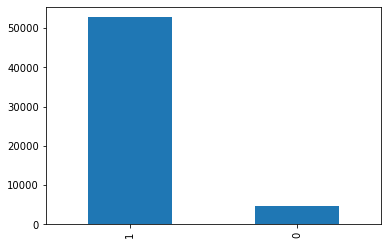

In [7]:
dataset.Label.value_counts().plot(kind='bar')

# 2. BERT - FineTuning(Sentence analasis)
## 2-1. 정수 인코딩

In [8]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("klue/bert-base")

In [9]:
X_train_list = x_train.tolist()
X_test_list = x_test.tolist()
y_train = y_train.tolist()
y_test = y_test.tolist()

In [10]:
X_train = tokenizer(X_train_list, truncation=True, padding=True)
X_test = tokenizer(X_test_list, truncation=True, padding=True)

In [11]:
print(X_train[0].type_ids)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [12]:
print(X_train[0].attention_mask)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## 2-2. 데이터셋 생성 및 모델 학습

In [13]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_train),
    y_train
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_test),
    y_test
))

In [2]:
from transformers import TFBertForSequenceClassification
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

In [6]:
import tensorflow as tf
model = TFBertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=2, from_pt=True)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
model.compute_loss

<bound method TFPreTrainedModel.compute_loss of <transformers.models.bert.modeling_tf_bert.TFBertForSequenceClassification object at 0x000001F1716F8A30>>

In [30]:
callback_earlystop = EarlyStopping(
    monitor="val_accuracy", 
    min_delta=0.001,
    patience=2)

model.fit(
    train_dataset.shuffle(5000).batch(16), epochs=5, batch_size=32,
    validation_data = val_dataset.shuffle(5000).batch(32),
    callbacks = [callback_earlystop]
)

Epoch 1/5
2870/2870 [==============================] - 1010s 352ms/step - loss: 0.0625 - accuracy: 0.9783 - val_loss: 0.0895 - val_accuracy: 0.9692
Epoch 2/5
2870/2870 [==============================] - 1003s 349ms/step - loss: 0.0481 - accuracy: 0.9838 - val_loss: 0.1245 - val_accuracy: 0.9662
Epoch 3/5
2870/2870 [==============================] - 1016s 354ms/step - loss: 0.0409 - accuracy: 0.9863 - val_loss: 0.1271 - val_accuracy: 0.9679


In [31]:
model.evaluate(val_dataset.batch(512))

23/23 [==============================] - 55s 2s/step - loss: 0.1271 - accuracy: 0.9679


[0.127106711268425, 0.9678543210029602]

# 3. 모델 저장

In [32]:
model.save_pretrained('BERT_model/bert-base')
tokenizer.save_pretrained('BERT_model/bert-base')

('BERT_model/bert-base\\tokenizer_config.json',
 'BERT_model/bert-base\\special_tokens_map.json',
 'BERT_model/bert-base\\vocab.txt',
 'BERT_model/bert-base\\added_tokens.json',
 'BERT_model/bert-base\\tokenizer.json')

# 4. 모델 로드 및 테스트

In [9]:
from transformers import TextClassificationPipeline

# 로드하기
loaded_tokenizer = BertTokenizerFast.from_pretrained('BERT_model/bert-base')
loaded_model = TFBertForSequenceClassification.from_pretrained('BERT_model/bert-base')

text_classifier = TextClassificationPipeline(
    tokenizer=loaded_tokenizer, 
    model=loaded_model, 
    framework='tf',
    return_all_scores=True
)

Some layers from the model checkpoint at BERT_model/bert-base were not used when initializing TFBertForSequenceClassification: ['dropout_75']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at BERT_model/bert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
C:\Users\DanielJeong\AppData\Roaming\Python\Python39\site-packages\tr

## 2-3. 모델 테스트

In [11]:
def show_sentiment(text):
    result = text_classifier(text)[0]
    print('부정일 확률 : ', round(result[0]['score'],3))
    print('긍정일 확률 : ', round(result[1]['score'],3))

In [12]:
 show_sentiment('위생상태 불량')

부정일 확률 :  0.986
긍정일 확률 :  0.014


In [13]:
show_sentiment('친절하네요')

부정일 확률 :  0.0
긍정일 확률 :  1.0


In [15]:
show_sentiment('양이 적어')

부정일 확률 :  0.646
긍정일 확률 :  0.354


In [16]:
show_sentiment('장소가 협소하네요')

부정일 확률 :  0.014
긍정일 확률 :  0.986


In [17]:
show_sentiment('비린맛이 심하네요')

부정일 확률 :  0.986
긍정일 확률 :  0.014


In [18]:
show_sentiment('맛은 좋지만 가성비가 떨어지네요')

부정일 확률 :  0.27
긍정일 확률 :  0.73


In [19]:
show_sentiment('알바가 친절하고 맛도 좋아요')

부정일 확률 :  0.0
긍정일 확률 :  1.0


In [20]:
show_sentiment('가성비 좋고, 맛도 무진장 좋아요')

부정일 확률 :  0.0
긍정일 확률 :  1.0


In [45]:
show_sentiment('개 좋다')

부정일 확률 :  0.0
긍정일 확률 :  1.0


In [46]:
show_sentiment('개 같다')

부정일 확률 :  0.985
긍정일 확률 :  0.015


In [26]:
show_sentiment('장사가 잘되니 초심을 잃었네요')

부정일 확률 :  0.986
긍정일 확률 :  0.014


In [48]:
show_sentiment('주차 자리가 협소하네요')

부정일 확률 :  0.104
긍정일 확률 :  0.896


In [49]:
show_sentiment('자리가 따닥따닥 붙여져 있네요')

부정일 확률 :  0.584
긍정일 확률 :  0.416


In [51]:
show_sentiment('기다려도 음식이 안나오네')

부정일 확률 :  0.982
긍정일 확률 :  0.018


In [52]:
show_sentiment('친절하네요')

부정일 확률 :  0.0
긍정일 확률 :  1.0


In [53]:
show_sentiment('주차 하기 힘듬')

부정일 확률 :  0.0
긍정일 확률 :  1.0


In [54]:
show_sentiment('주차')

부정일 확률 :  0.191
긍정일 확률 :  0.809


In [55]:
show_sentiment('주차장이 좁다')

부정일 확률 :  0.009
긍정일 확률 :  0.991


In [ ]:
show_sentiment('주차장이 좁다')